In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import re
import aiohttp
from deep_translator import GoogleTranslator
import asyncio
from bs4 import BeautifulSoup
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('base-joconde-extrait.csv', delimiter=';')

/tmp/ipykernel_378768/4259321499.py:1: DtypeWarning: Columns (1,26,34,35,36,38,42,44,47,49,51,52,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('base-joconde-extrait.csv', delimiter=';')


In [3]:
df.columns

Index(['Reference', 'Ancien_depot', 'Appellation', 'Ancienne_appartenance',
       'Ancienne_attribution', 'Auteur', 'Bibliographie', 'Commentaires',
       'Presence_image', 'Date_d_acquisition', 'Date_de_depot',
       'Decouverte_collecte', 'Denomination', 'Lieu_de_depot', 'Description',
       'Mesures', 'Date_de_mise_a_jour', 'Date_creation', 'Domaine', 'Region',
       'Departement', 'Date_sujet_represente', 'Ecole_pays', 'Epoque',
       'Exposition', 'Genese', 'Geographie_historique', 'Inscription',
       'Numero_inventaire', 'Appellation_Musee_de_France', 'Lien_base_Arcade',
       'Lieu_de_creation_utilisation', 'Localisation', 'Ville', 'Lien_Video',
       'MANQUANT', 'MANQUANT_COM', 'Millesime_de_creation',
       'Millesime_d_utilisation', 'Code_Museofile', 'Nom_officiel_musee',
       'Genre', 'Onomastique', 'Precisions_sur_l_auteur',
       'Precisions_decouverte_collecte', 'Periode_de_l_original_copie',
       'Periode_de_creation', 'Periode_d_utilisation',
       'Pre

In [4]:
# Get unique values from 'Periode_de_creation'
unique_periode = df['Periode_de_creation'].dropna().unique()

# Get unique values from 'Millesime_de_creation'
unique_millesime = df['Millesime_de_creation'].dropna().unique()

# If you want to sort them for clarity
unique_periode_sorted = sorted(unique_periode)
unique_millesime_sorted = sorted(pd.to_numeric(pd.Series(unique_millesime), errors='coerce').dropna().astype(int).unique())

# Print or inspect
print("Unique values in 'Periode_de_creation':")
print(unique_periode_sorted)

print("\nUnique values in 'Millesime_de_creation':")
print(unique_millesime_sorted)


Unique values in 'Periode_de_creation':
['10e siècle', '10e siècle av JC', '10e siècle av JC;1er quart 8e siècle av JC', '10e siècle av JC;1er siècle av JC', '10e siècle av JC;4e siècle av JC', '10e siècle av JC;8e siècle av JC', '10e siècle av JC;9e siècle av JC', '10e siècle av JC;9e siècle av JC;8e siècle av JC', '10e siècle av JC;9e siècle av JC;8e siècle av JC;7e siècle av JC', '10e siècle;11e siècle', '10e siècle;11e siècle;12e siècle', '10e siècle;11e siècle;12e siècle;13e siècle', '10e siècle;11e siècle;12e siècle;13e siècle;14e siècle', '10e siècle;11e siècle;12e siècle;13e siècle;14e siècle;15e siècle', '10e siècle;11e siècle;12e siècle;13e siècle;14e siècle;1ère moitié 15e siècle', '10e siècle;12e siècle', '10e siècle;12e siècle;13e siècle;14e siècle;15e siècle;4e quart 15e siècle', '10e siècle;16e siècle;17e siècle', '10e siècle;9e siècle', '11e siècle', '11e siècle av JC;10e siècle av JC', '11e siècle av JC;10e siècle av JC;9e siècle av JC', '11e siècle av JC;10e siècle av

In [7]:
# Create a copy of the original dataframe
art_filtered = df.copy()

# Convert Millesime_de_creation to numeric, coercing errors to NaN
art_filtered['Millesime_de_creation'] = pd.to_numeric(art_filtered['Millesime_de_creation'], errors='coerce')

# Filter for years between 1600 and 1899
year_mask = (art_filtered['Millesime_de_creation'] >= 1600) & (art_filtered['Millesime_de_creation'] <= 1899)

# Filter for artwork with available images
art_filtered['has_image'] = art_filtered['Presence_image'].astype(str).str.lower()
image_mask = art_filtered['has_image'].isin(['1', 'true', 'yes', 'oui', 't', 'y', 'o'])

# Filter for paintings - check both Denomination and Genre columns
painting_terms = ['peinture', 'tableau', 'huile sur toile', 'painting', 'oil on canvas']
denomination_mask = art_filtered['Denomination'].str.lower().str.contains('|'.join(painting_terms), na=False)
genre_mask = art_filtered['Genre'].str.lower().str.contains('|'.join(painting_terms), na=False)

# Combine all masks
final_mask = year_mask & image_mask & (denomination_mask | genre_mask)

# Apply the filters
art_filtered = art_filtered[final_mask]

# Print statistics
print(f"Original dataset had {len(df)} artworks")
print(f"After filtering for years 1600-1899: {year_mask.sum()} artworks")
print(f"After filtering for available images: {(year_mask & image_mask).sum()} artworks")
print(f"Final dataset has {len(art_filtered)} paintings from 1600-1899 with images")

# Display first few rows of the filtered dataset with relevant columns
columns_to_show = ['Reference', 'Millesime_de_creation', 'Periode_de_creation', 'Denomination', 
                   'Genre', 'Auteur', 'Titre', 'Presence_image']
art_filtered[columns_to_show].head()

Original dataset had 684913 artworks
After filtering for years 1600-1899: 81120 artworks
After filtering for available images: 66173 artworks
Final dataset has 11581 paintings from 1600-1899 with images


,Reference,Millesime_de_creation,Periode_de_creation,Denomination,Genre,Auteur,Titre,Presence_image
324,M1099000039,1878.0,4e quart 19e siècle,tableau,NaN,LYON Léon (peintre);SOCIETE GODCHAUX (fabricant),Portrait de Guetschlick et de Samson Godchaux,oui
376,07290022192,1827.0,2e quart 19e siècle,tableau,NaN,DAEL Jan Frans Van,Corbeille de fleurs et grappe de raisin ; Fleurs et fruits,oui
377,07290021225,1897.0,4e quart 19e siècle,tableau,féminin,HAIN Marguerite,"Moyettes sur la falaise à Huppain, près de Port-en-Bessin",oui
378,07290022485,1898.0,4e quart 19e siècle,tableau,NaN,LEMAITRE Léon Jules,Rue des boucheries-Saint-Ouen à Rouen,oui
379,07290021636,1895.0,4e quart 19e siècle,tableau,NaN,BAUDRY Bernard,L'atelier : le repos du modèle (titre récent) ; le repos du modele (titre d'origine),oui


In [6]:
# Create SSL context for insecure HTTP requests (must do because my computer
# doesn't recognize the French government's DNS).

ssl_context = ssl.create_default_context()
ssl_context.check_hostname = False
ssl_context.verify_mode = ssl.CERT_NONE

In [ ]:
# Scrape and save the image urls for paintings using get_urls().
# - d_df: the df to get paintings from.
# - name: the name of the file to save urls to.

async def fetch(session, url):
    async with session.get(url, ssl=ssl_context) as response:
        return await response.read()

async def get_images(session, url):
    try:
        html = await fetch(session, url)
        soup = BeautifulSoup(html, 'html.parser')
        first_img_tag = soup.select_one(".fieldImages img, .swiper-slide img")
        first_image_url = first_img_tag["src"] if first_img_tag else None
        return first_image_url
    except Exception as e:
        raise e

async def get(urls):
    async with aiohttp.ClientSession() as session:
        tasks = [get_images(session, url) for url in urls]
        results = await asyncio.gather(*tasks)
        return results

def download(results, name):
    with open(f'{name}.log', 'w') as file:
        for s in results:
            file.write(s + '\n')

async def get_urls(d_df, name):
    base_url = "https://www.pop.culture.gouv.fr/notice/joconde/{number}"
    urls = [base_url.format(number=i) for i in d_df['Reference']]
    results = await get(urls)
    download(results, name)

In [15]:
# Generate list of image urls for all French paintings.
await get_urls(art_filtered, 'all')

Paintings count by century:
- 17th (1600-1700) Century: 1168 paintings
- 18th (1701-1800) Century: 1767 paintings
- 19th (1801-1899) Century: 8646 paintings


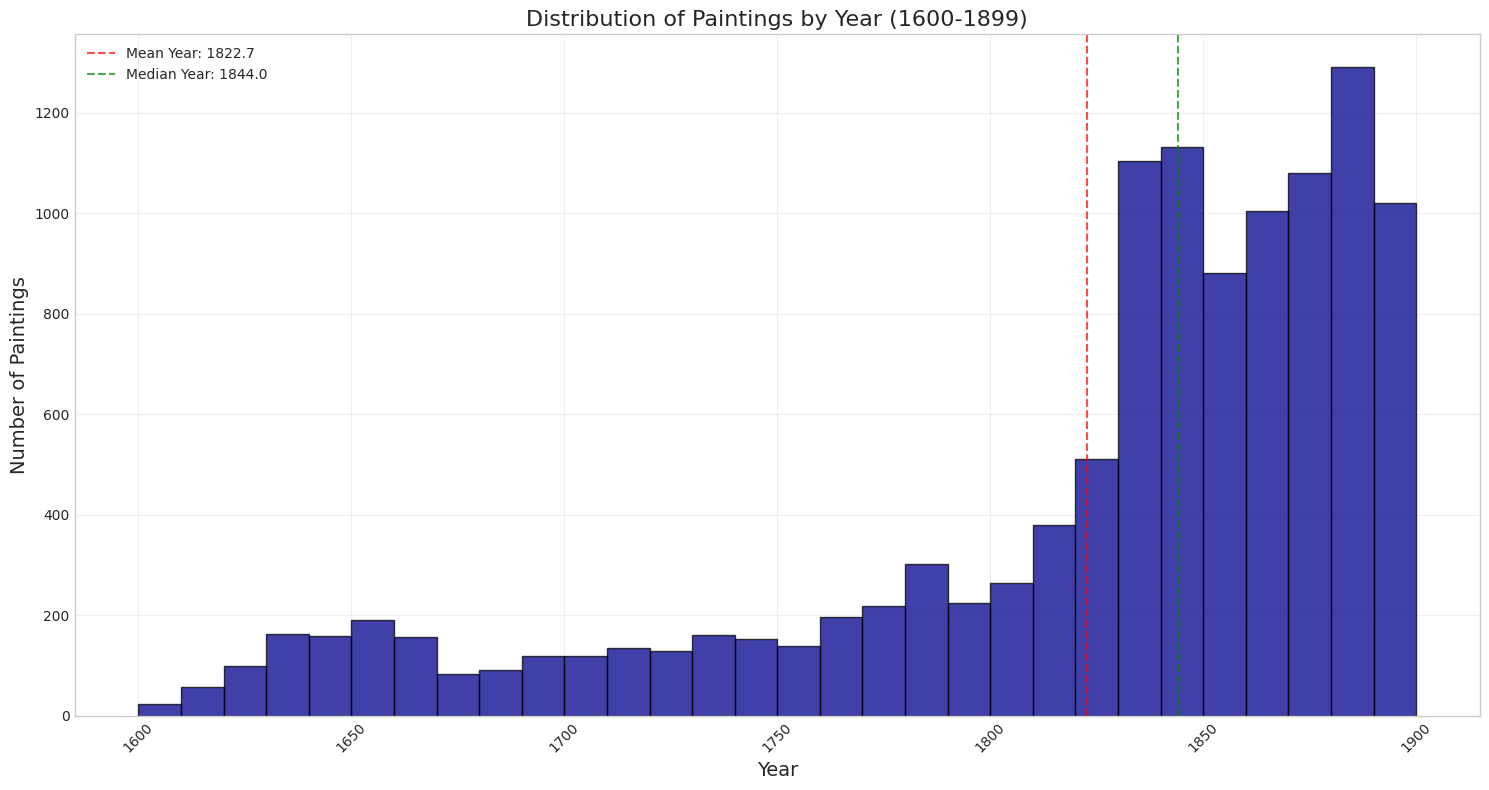

In [24]:
# Set the style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Ensure we're working with the filtered dataset
# Filter for only 1600-1899 range and remove any NaN values
paintings_1600_1899 = art_filtered[
    (art_filtered['Millesime_de_creation'] >= 1600) & 
    (art_filtered['Millesime_de_creation'] <= 1899)
].dropna(subset=['Millesime_de_creation'])

# Create the histogram
plt.figure(figsize=(15, 8))

# Create the histogram with custom bins (10-year intervals)
bins = np.arange(1600, 1901, 10)  # From 1600 to 1900 in steps of 10
plt.hist(paintings_1600_1899['Millesime_de_creation'], bins=bins, alpha=0.75, 
         color='darkblue', edgecolor='black')

# Add a title and labels
plt.title('Distribution of Paintings by Year (1600-1899)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Paintings', fontsize=14)

# Add a grid for better readability
plt.grid(True, alpha=0.3)

# Make x-axis labels more readable by rotating them and showing fewer labels
plt.xticks(bins[::5], rotation=45)  # Show every 5th bin label (50-year intervals)

# Add context with text annotations
avg_year = paintings_1600_1899['Millesime_de_creation'].mean()
median_year = paintings_1600_1899['Millesime_de_creation'].median()
plt.axvline(x=avg_year, color='red', linestyle='--', alpha=0.7, 
            label=f'Mean Year: {avg_year:.1f}')
plt.axvline(x=median_year, color='green', linestyle='--', alpha=0.7, 
            label=f'Median Year: {median_year:.1f}')

# Add a legend
plt.legend()

# Improve layout
plt.tight_layout()

# Count paintings per century for additional context
centuries = {
    '17th (1600-1700)': ((paintings_1600_1899['Millesime_de_creation'] >= 1600) & 
                          (paintings_1600_1899['Millesime_de_creation'] <= 1700)).sum(),
    '18th (1701-1800)': ((paintings_1600_1899['Millesime_de_creation'] >= 1701) & 
                          (paintings_1600_1899['Millesime_de_creation'] <= 1800)).sum(),
    '19th (1801-1899)': ((paintings_1600_1899['Millesime_de_creation'] >= 1801) & 
                          (paintings_1600_1899['Millesime_de_creation'] <= 1899)).sum()
}

print("Paintings count by century:")
for century, count in centuries.items():
    print(f"- {century} Century: {count} paintings")

# Show the plot
plt.show()